In [2]:
import os  # Operating system interfaces
import numpy as np
import cv2 
import tensorflow as tf                                    # TensorFlow deep learning framework
import matplotlib.pyplot as plt                            # Plotting library
import matplotlib.image as mpimg    
from sklearn.model_selection import train_test_split    
from tensorflow.keras import layers                   # Image loading and manipulation library
from tensorflow.keras.models import Sequential, Model      # Sequential and Functional API for building models
from tensorflow.keras.optimizers import Adam               # Adam optimizer for model training
from tensorflow.keras.callbacks import EarlyStopping       # Early stopping callback for model training
from tensorflow.keras.regularizers import l1, l2           # L1 and L2 regularization for model regularization
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Data augmentation and preprocessing for images
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, AveragePooling2D, MaxPooling2D, BatchNormalization  
# Various types of layers for building neural networks
from tensorflow.keras.applications import DenseNet121, EfficientNetB4, Xception, VGG16, VGG19   # Pre-trained models for transfer learning

import ClassificationModel as CM

In [3]:
# seed = 1  # You can use any integer value as the seed
# BATCH_SIZE = 32                                              # 32
# IMG_SIZE = (256, 256)

# train_data = tf.keras.utils.image_dataset_from_directory(
#     "C:/Users/testb/Desktop/grapevine_leaf/Grapevine_Leaves_Image_Dataset",
#     labels='inferred',
#     label_mode='categorical',
#     image_size=IMG_SIZE,
#     batch_size=BATCH_SIZE,
#     validation_split=0.2,  # 20% of the data will be used for validation
#     subset='training',  # Specify that this is the training subset
#     seed=seed  # Add seed argument
# )

# validation_data = tf.keras.utils.image_dataset_from_directory(
#     "C:/Users/testb/Desktop/grapevine_leaf/Grapevine_Leaves_Image_Dataset",
#     labels='inferred',
#     label_mode='categorical',
#     image_size=IMG_SIZE,
#     batch_size=BATCH_SIZE,
#     validation_split=0.2,  # 20% of the data will be used for validation
#     subset='validation',  # Specify that this is the validation subset
#     seed=seed  # Add seed argument
# )

# train_data = train_data.map(lambda x, y: (x / 255.0, y))
# validation_data = validation_data.map(lambda x, y: (x / 255.0, y))
# # normalization_layer = layers.Rescaling(1./255)
# # train_data.map(lambda x, y: (normalization_layer(x), y))
# # validation_data.map(lambda x, y: (normalization_layer(x), y))
# # class_names = train_data.class_names
# # print(class_names)

In [5]:
IMG_SIZE = (256, 256)
BATCH_SIZE = 32
seed = 11
all_data = tf.keras.utils.image_dataset_from_directory(
    "C:/Users/testb/Desktop/jupyter/grapevine_leaf/Grapevine_Leaves_Image_Dataset",
    labels='inferred',
    label_mode='categorical',  # etichette one-hot
    image_size=IMG_SIZE,  # ad esempio (224, 224)
    batch_size=None  # nessun batch, ottieni tutte le immagini una per una
)

# Estrai le immagini e le etichette dal dataset
image_list = []
label_list = []

for image, label in all_data:
    image_list.append(image.numpy())  # Converti l'immagine in NumPy array
    label_list.append(label.numpy())  # Converti l'etichetta in NumPy array

# Converti le liste in array NumPy
image_array = np.array(image_list)
label_array = np.array(label_list)

print(f"image_array.shape: {image_array.shape}")
print(f"label_array.shape: {label_array.shape}")

# Primo split: ottieni training (70%) e temp (30%) per test+validation
X_train, X_temp, y_train, y_temp = train_test_split(
    image_array, label_array, test_size=0.3, random_state=seed  # 30% per validation+test
)

# Secondo split: dividi temp in validation (10%) e test (20%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.66, random_state=seed  # 2/3 per test, 1/3 per validation
)

# Convertire i dati divisi in tf.data.Dataset
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE)
validation_data = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)

Not_norm = True

Found 500 files belonging to 5 classes.
image_array.shape: (500, 256, 256, 3)
label_array.shape: (500, 5)


11
(32, 256, 256, 3)
tf.Tensor([1. 0. 0. 0. 0.], shape=(5,), dtype=float32)


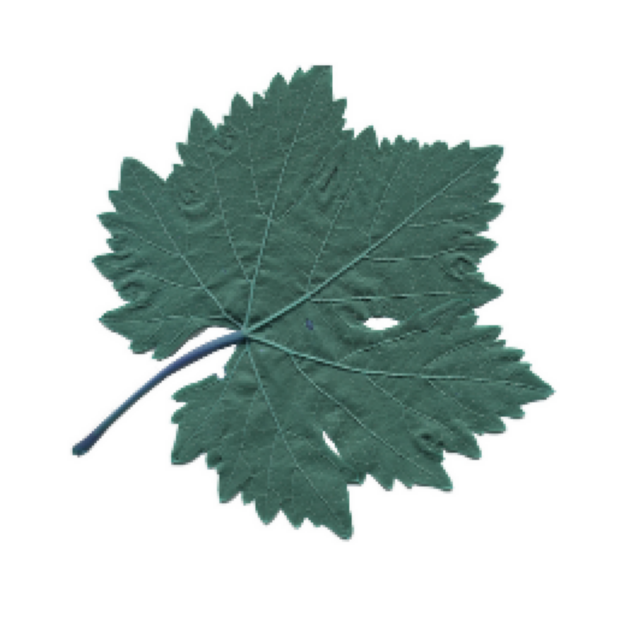

In [6]:
print(train_data.cardinality().numpy()) #num BATCH
for image_batch, labels_batch in train_data:
    print(image_batch.shape)
    print(labels_batch[0]) # contiene one-hot delle classi
    break

img = image_batch[10,:,:,:].numpy().astype(np.uint8)
# Converti l'immagine da BGR a RGB (OpenCV usa BGR per default)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Crea una figura e un'asse
plt.figure(figsize=(8, 8))  # Puoi regolare le dimensioni della figura
plt.imshow(img)  # Mostra l'immagine
plt.axis('off')  # Disabilita gli assi
plt.show()  # Mostra la figura


In [7]:
# Normalizzazione - NOTA: tf.data.Dataset = img, label
if (Not_norm):
    train_data = train_data.map(lambda x, y: (x / 255.0, y))
    validation_data = validation_data.map(lambda x, y: (x / 255.0, y))
    test_data = test_data.map(lambda x, y: (x / 255.0, y))
    Not_norm = False
    
for image_batch, labels_batch in train_data:
    print(np.min(image_batch[10,100,:,:].numpy()))
    break

0.1514888


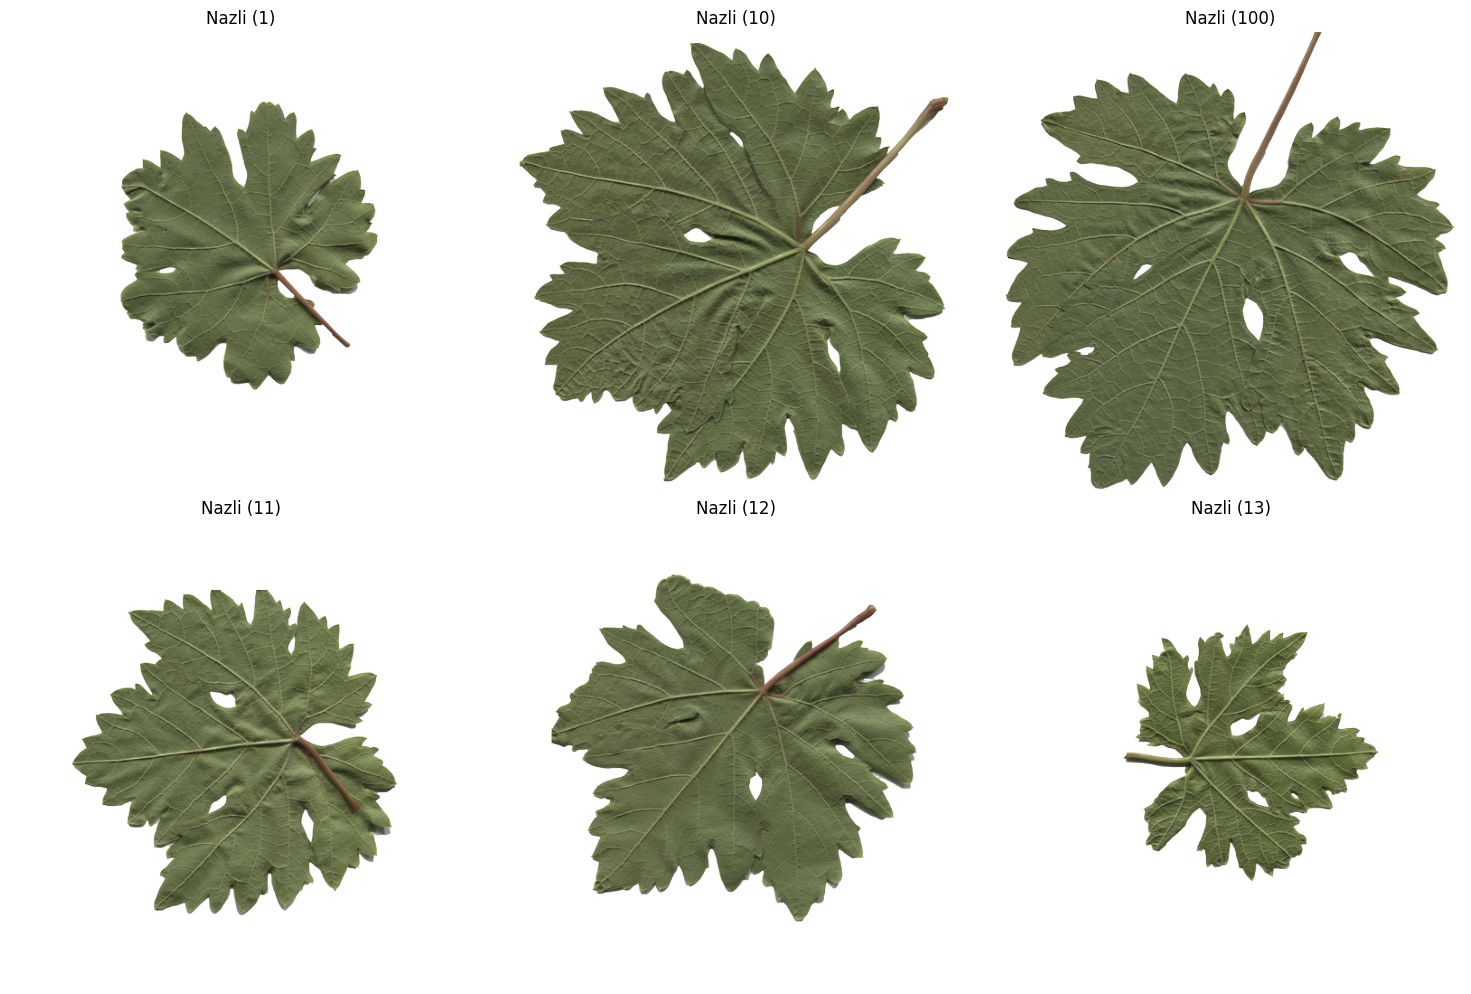

In [9]:
# Path to the directory containing images
path = "C:/Users/testb/Desktop/jupyter/grapevine_leaf/Grapevine_Leaves_Image_Dataset/Nazli"
# Get a list of all image file names in the directory
image_files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
# Display the first 6 images with their labels
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i in range(6):
    # Get the image file name and its label
    image_file = image_files[i]
    label = image_file.split('.')[0]

    # Load and display the image
    img_path = os.path.join(path, image_file)
    img = mpimg.imread(img_path)
    ax = axs[i // 3, i % 3]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(label)

plt.tight_layout()
plt.show()

In [15]:
num_classes = y_train.shape[1]
model = CM.GenerateModel(num_classes)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       524,35

 Total params: 20,549,061 (78.39 MB)

 Trainable params: 5,244,293 (20.01 MB)

 Non-trainable params: 15,304,768 (58.38 MB)

In [24]:
alpha = 0.1
epochs = 5
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=alpha), metrics=['categorical_accuracy'])

In [25]:
history = model.fit(train_data, epochs=epochs, verbose=1)

Epoch 1/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 78s 7s/step - categorical_accuracy: 0.1896 - loss: 1.6212
Epoch 2/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 80s 7s/step - categorical_accuracy: 0.2433 - loss: 1.6079
Epoch 3/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 99s 9s/step - categorical_accuracy: 0.1779 - loss: 1.6179
Epoch 4/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 96s 8s/step - categorical_accuracy: 0.1779 - loss: 1.6164
Epoch 5/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 79s 7s/step - categorical_accuracy: 0.1779 - loss: 1.6131


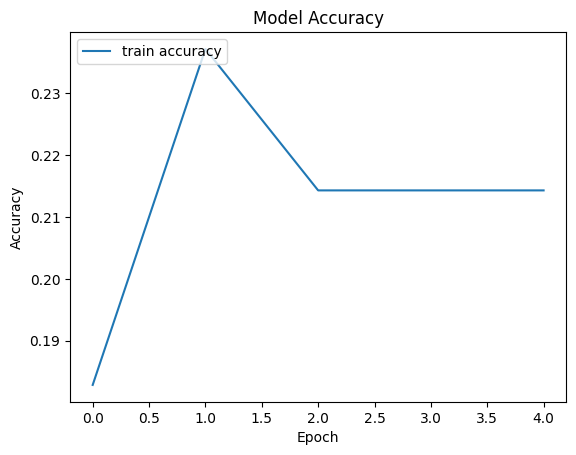

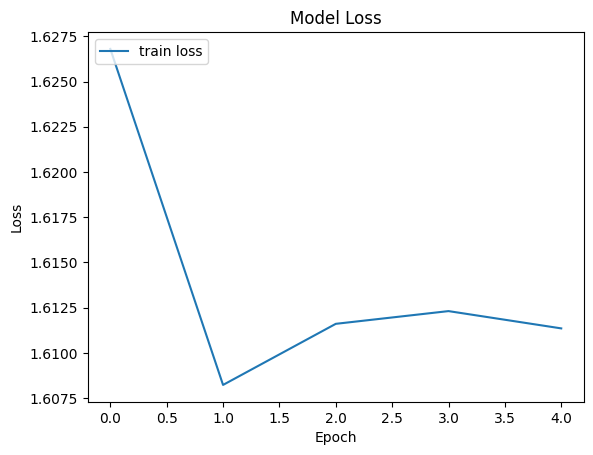

In [27]:
# Plot training & validation accuracy values
plt.plot(history.history['categorical_accuracy'], label='train accuracy')
# plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'], label='train loss')
# plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [35]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
y_pred = model.predict(X_val)
print(y_pred)
print(y_val)
max_indices_pred = np.argmax(y_pred, axis=1) #prediction as class number
max_indices_val = np.argmax(y_val, axis=1) #prediction as class number

# Create the confusion matrix
nn_cm = confusion_matrix(max_indices_val, max_indices_pred)
accuracy = accuracy_score(max_indices_val, max_indices_pred)
precision = precision_score(max_indices_val, max_indices_pred, average='macro')
recall = recall_score(max_indices_val, max_indices_pred, average='macro')
f1 = f1_score(max_indices_val, max_indices_pred, average='macro')

print(nn_cm)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step
[[0.18996398 0.20217457 0.21510275 0.2034127  0.18934591]
 [0.18996398 0.20217457 0.21510275 0.2034127  0.18934591]
 [0.18996398 0.20217457 0.21510275 0.2034127  0.18934591]
 [0.18996398 0.20217457 0.21510275 0.2034127  0.18934591]
 [0.18996398 0.20217457 0.21510275 0.2034127  0.18934591]
 [0.18996398 0.20217457 0.21510275 0.2034127  0.18934591]
 [0.18996398 0.20217457 0.21510275 0.2034127  0.18934591]
 [0.18996398 0.20217457 0.21510275 0.2034127  0.18934591]
 [0.18996398 0.20217457 0.21510275 0.2034127  0.18934591]
 [0.18996398 0.20217457 0.21510275 0.2034127  0.18934591]
 [0.18996398 0.20217457 0.21510275 0.2034127  0.18934591]
 [0.18996398 0.20217457 0.21510275 0.2034127  0.18934591]
 [0.18996398 0.20217457 0.21510275 0.2034127  0.18934591]
 [0.18996398 0.20217457 0.21510275 0.2034127  0.18934591]
 [0.18996398 0.20217457 0.21510275 0.2034127  0.18934591]
 [0.18996398 0.20217457 0.21510275 0.2034127  0.18934591]
 [0.18996398 0.20217457 0.21510275 0

c:\Users\testb\Desktop\jupyter\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
model.save('my_model')
# loaded_model = tf.keras.models.load_model('my_model')